# Import Libraries, Functions, and dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/ENGG_680_Project/Database/

/content/drive/MyDrive/ENGG_680_Project/Database


In [3]:
!ls

 catboost_info			  'predictions_with_index Rect.csv'
 _OLD				  'SS CFST Database_Finalised_for correlation.xlsx'
'predictions_with_index Cir.csv'


In [4]:
pip install xgboost

In [5]:
#importing libraries and linear regression from scikit learn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV

#Loading database
df = pd.read_excel("SS CFST Database_Finalised_for correlation.xlsx")
df_circ = pd.read_excel("SS CFST Database_Finalised_for correlation.xlsx", sheet_name=2)

# Rectangular XGBoost

In [6]:
# Define X (features) and y (target)
X = df.drop(columns=['N_Test'])
y = df['N_Test']

#printing shape to confirm number of features and values
print(X.shape)
print(y.shape)

(211, 10)
(211,)


In [7]:
# Split the data into training and test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional: Standardize features
    ('xgboost', XGBRegressor(random_state=42))  # XGBoost model
])

In [9]:
# Define hyperparameter grid for GridSearchCV
param_grid = {
    'xgboost__n_estimators': [100, 200, 300],
    'xgboost__max_depth': [3, 5, 7],
    'xgboost__learning_rate': [0.01, 0.1, 0.2],
    'xgboost__subsample': [0.6, 0.8, 1.0],
    'xgboost__colsample_bytree': [0.6, 0.8, 1.0],
    'xgboost__reg_alpha': [0, 1, 10],
    'xgboost__reg_lambda': [1, 10, 100]
}

In [10]:
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='r2',           # Use R^2 for ranking
    cv=3,                   # 3-fold cross-validation
    verbose=2,
    n_jobs=-1               # Use all available CPU cores
)

In [11]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgboost',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None,
                                                     grow_policy=None,
                                                     importance_type...
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgboost__colsample_bytree': [0.6, 0.8, 1.0],
                         'xgboost__learning_rate': [0.01, 0.1, 0.2],
                         'xgboost__max_depth': [3, 5, 7],
                         'xgboost__n_estimators': [100, 200, 300],
                         'xgboost__reg_alpha': [0, 1, 10],
                         'xgboost__reg_lambda': [1, 10, 100],
                         'xgboost__subsample': [0.6, 0.8, 1.0]},
             scoring='r2', verbose=2)

In [12]:
# Retrieve the best pipeline and hyperparameters
best_pipeline = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'xgboost__colsample_bytree': 0.6, 'xgboost__learning_rate': 0.2, 'xgboost__max_depth': 3, 'xgboost__n_estimators': 300, 'xgboost__reg_alpha': 10, 'xgboost__reg_lambda': 1, 'xgboost__subsample': 0.8}


In [13]:
# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = np.finfo(np.float64).eps
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Predictions on training and test sets
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

# Training set metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

# Test set metrics
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# Display results
print("\nTraining Set Metrics:")
print(f"  R^2: {train_r2:.3f}")
print(f"  MSE: {train_mse:.3f}")
print(f"  MAPE: {train_mape:.3f}%")

print("\nTest Set Metrics:")
print(f"  R^2: {test_r2:.3f}")
print(f"  MSE: {test_mse:.3f}")
print(f"  MAPE: {test_mape:.3f}%")


Training Set Metrics:
  R^2: 0.999
  MSE: 748.093
  MAPE: 1.566%

Test Set Metrics:
  R^2: 0.952
  MSE: 62378.453
  MAPE: 7.165%


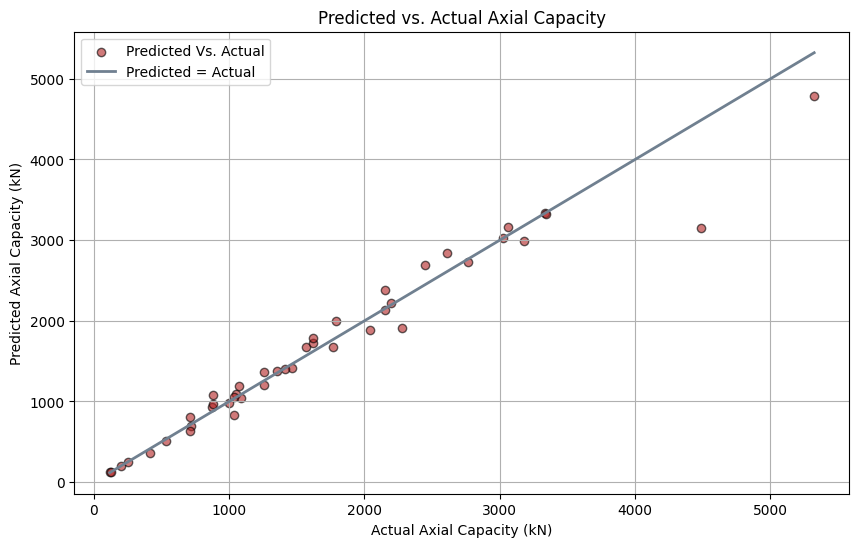

In [14]:
# Scatter Plot: Predicted vs. Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='firebrick', edgecolors='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'slategray', linewidth=2)
plt.xlabel('Actual Axial Capacity (kN)')
plt.ylabel('Predicted Axial Capacity (kN)')
plt.title('Predicted vs. Actual Axial Capacity')
plt.legend(['Predicted Vs. Actual', 'Predicted = Actual'])
plt.savefig('XGBoost.png')
plt.grid(True)
plt.show()

# Circular XGboost

In [ ]:
# Define X (features) and y (target)
X = df_circ.drop(columns=['N_Test'])
y = df_circ['N_Test']

#printing shape to confirm number of features and values
print(X.shape)
print(y.shape)

(211, 9)
(211,)


In [ ]:
# Split the data into training and test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional: Standardize features
    ('xgboost', XGBRegressor(random_state=42))  # XGBoost model
])

In [ ]:
# Define hyperparameter grid for GridSearchCV
param_grid = {
    'xgboost__n_estimators': [100, 200, 300],
    'xgboost__max_depth': [3, 5, 7],
    'xgboost__learning_rate': [0.01, 0.1, 0.2],
    'xgboost__subsample': [0.6, 0.8, 1.0],
    'xgboost__colsample_bytree': [0.6, 0.8, 1.0],
    'xgboost__reg_alpha': [0, 1, 10],
    'xgboost__reg_lambda': [1, 10, 100]
}

In [ ]:
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='r2',           # Use R^2 for ranking
    cv=3,                   # 3-fold cross-validation
    verbose=2,
    n_jobs=-1               # Use all available CPU cores
)

In [ ]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgboost',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None,
                                                     grow_policy=None,
                                                     importance_type...
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgboost__colsample_bytree': [0.6, 0.8, 1.0],
                         'xgboost__learning_rate': [0.01, 0.1, 0.2],
                         'xgboost__max_depth': [3, 5, 7],
                         'xgboost__n_estimators': [100, 200, 300],
                         'xgboost__reg_alpha': [0, 1, 10],
                         'xgboost__reg_lambda': [1, 10, 100],
                         'xgboost__subsample': [0.6, 0.8, 1.0]},
             scoring='r2', verbose=2)

In [ ]:
# Retrieve the best pipeline and hyperparameters
best_pipeline = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'xgboost__colsample_bytree': 0.6, 'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 3, 'xgboost__n_estimators': 200, 'xgboost__reg_alpha': 10, 'xgboost__reg_lambda': 1, 'xgboost__subsample': 0.6}


In [ ]:
# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = np.finfo(np.float64).eps
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Predictions on training and test sets
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

# Training set metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

# Test set metrics
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# Display results
print("\nTraining Set Metrics:")
print(f"  R^2: {train_r2:.3f}")
print(f"  MSE: {train_mse:.3f}")
print(f"  MAPE: {train_mape:.3f}%")

print("\nTest Set Metrics:")
print(f"  R^2: {test_r2:.3f}")
print(f"  MSE: {test_mse:.3f}")
print(f"  MAPE: {test_mape:.3f}%")


Training Set Metrics:
  R^2: 0.999
  MSE: 9173.283
  MAPE: 6.638%

Test Set Metrics:
  R^2: 0.978
  MSE: 58779.394
  MAPE: 18.439%


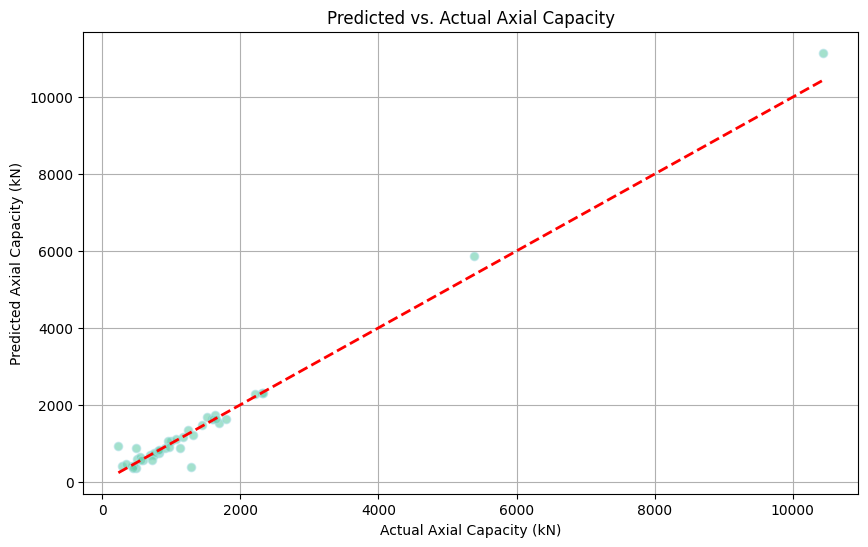

In [ ]:
# Scatter Plot: Predicted vs. Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='mediumaquamarine', edgecolors='powderblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Axial Capacity (kN)')
plt.ylabel('Predicted Axial Capacity (kN)')
plt.title('Predicted vs. Actual Axial Capacity')
plt.grid(True)
plt.show()